# Data

In [ ]:
import os
import tensorflow as tf
import numpy as np
from PIL import Image

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Define folder paths
output_folder = "mnist_sample_data"
train_folder = os.path.join(output_folder, "train")
test_folder = os.path.join(output_folder, "test")

# Create directories
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Set sample size
train_sample_size = 500  # Number of training images
test_sample_size = 500   # Number of testing images

# Save a subset of training images
for i, (image, label) in enumerate(zip(x_train[:train_sample_size], y_train[:train_sample_size])):
    label_folder = os.path.join(train_folder, str(label))
    os.makedirs(label_folder, exist_ok=True)
    image_path = os.path.join(label_folder, f"{i}.png")
    Image.fromarray(image).save(image_path)

# Save a subset of test images
for i, (image, label) in enumerate(zip(x_test[:test_sample_size], y_test[:test_sample_size])):
    label_folder = os.path.join(test_folder, str(label))
    os.makedirs(label_folder, exist_ok=True)
    image_path = os.path.join(label_folder, f"{i}.png")
    Image.fromarray(image).save(image_path)

print(f"MNIST sample dataset (1000 images) has been saved in '{output_folder}' folder.")

# CNN- Load from a Directory

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Define data paths
train_dir = "mnist_sample_data/train"
test_dir = "mnist_sample_data/test"

# Define hyperparameters
BATCH_SIZE = 32
IMG_SIZE = (128, 128)  # Resize images for transfer learning

# Load training and validation datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode="int")
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode="int")

# Data Augmentation
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal"),
                                      layers.RandomRotation(0.2),
                                      layers.RandomZoom(0.2),])

# Apply prefetching for performance optimization
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y)).prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

Found 500 files belonging to 10 classes.


2025-02-20 18:34:42.783963: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-02-20 18:34:42.784141: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-02-20 18:34:42.784150: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-02-20 18:34:42.784332: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-20 18:34:42.784358: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 500 files belonging to 10 classes.


# CNN Transfer learning

In [ ]:
# Load MobileNetV2 as a base model (Transfer Learning)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE + (3,), 
                                               include_top=False,  # Remove fully connected layers
                                               weights="imagenet")
base_model.trainable = False  # Freeze the base model

# Build the Transfer Learning Model
# Define Input Layer
inputs = keras.Input(shape=(128, 128, 3))
x = base_model(inputs, training=False)  # Apply Pretrained Model # Ensure batch norm layers don't update
x = layers.GlobalAveragePooling2D()(x) # Global Average Pooling
x = layers.Dense(128, activation="relu")(x) # Fully Connected Layers
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(10, activation="softmax")(x) # Output Layer (10 Classes)

# Create Model
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(train_ds, validation_data=test_ds, epochs=3)

# Plot training results
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Training Accuracy vs Validation Accuracy")
plt.show()


# CNN Vanilla

Epoch 1/3
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.1616 - loss: 30.1430 - val_accuracy: 0.2400 - val_loss: 50.7954
Epoch 2/3
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.2227 - loss: 41.4141 - val_accuracy: 0.1460 - val_loss: 55.6622
Epoch 3/3
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.2966 - loss: 45.6548 - val_accuracy: 0.2900 - val_loss: 33.8563


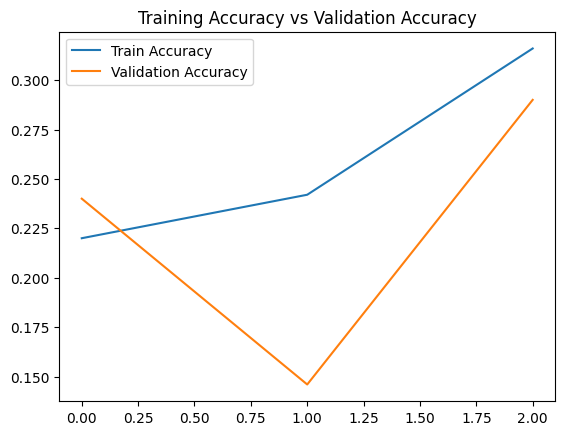

In [7]:
# Define Input Layer
inputs = keras.Input(shape=(128, 128, 3))

# Convolutional Layers
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

# Flatten and Fully Connected Layers
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(10, activation='softmax')(x)

# Create Model
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_ds, validation_data=test_ds, epochs=3)

# predict
y_test = np.concatenate([y for _, y in test_ds])
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis = 1)

from sklearn.metrics import f1_score, classification_report
report = classification_report(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')


In [ ]:
y_test = np.concatenate([y for _, y in test_ds])

y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis = 1)

from sklearn.metrics import f1_score, classification_report
report = classification_report(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')

# Print classification reports
print("Classification Report:\n", report)
print("F1 Macro Score:", f1_macro)
print("--"*10)